In [1]:
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

/opt/anaconda3/envs/model/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Exploratory Data Analysis

Steps:
1. Basic statistical overview: Combine the portfolio returns and betas basic statistics. 
2. Statistical analysis: Find which portfolios' mean beta aren't statistically different than 1 and which portfolio's have a mean is statistically higher than the mean market return. 
3. Visualization: Compare portfolios from step 2 to the market to look for trends. 
4. Stock comparison: Look to see common stocks in these portfolios and/or common groupings of stocks. 

In [2]:
# Read in all the data from data cleaning
betas = pd.read_csv("../data/100portfolioBetas_v2.csv", index_col=0)
returns = pd.read_csv("../data/100portfolioReturns.csv", index_col=0)
stocks = pd.read_csv("../data/100portfolioStocks.csv", index_col=0)

# Change the indexes to datetime
betas.index = pd.to_datetime(betas.index)
returns.index = pd.to_datetime(returns.index)

## Basic Statistical Overview

By creating a dataframe that includes both the statistics of the returns and the betas it is easy to compare and visualize comparisons of these values for each portfolio. 

In [3]:
b_stats = betas.describe().T
r_stats = returns.describe().T

stats = b_stats.join(r_stats, how="inner", lsuffix="_b", rsuffix="_r")
stats.head()

,count_b,mean_b,std_b,min_b,25%_b,50%_b,75%_b,max_b,count_r,mean_r,std_r,min_r,25%_r,50%_r,75%_r,max_r
0,2515.0,1.211338,0.140025,0.668505,1.183537,1.241150,1.291695,1.866705,2516.0,0.991595,0.704622,-0.075057,0.438101,0.835434,1.383996,2.644091
1,2515.0,1.337033,0.142973,0.718681,1.295132,1.341026,1.429063,1.548098,2516.0,1.160865,0.929967,-0.093435,0.520766,0.897628,1.515566,3.768864
2,2515.0,1.145882,0.185330,0.829681,0.977397,1.105573,1.348351,1.436692,2516.0,1.022900,0.846012,-0.089761,0.369817,0.782091,1.495210,3.065775
3,2515.0,0.845498,0.054023,0.656666,0.812034,0.856795,0.886490,1.002412,2516.0,0.660886,0.469329,-0.072149,0.350925,0.591886,0.865363,2.006561
4,2515.0,1.137738,0.173708,0.782842,1.014440,1.150396,1.283309,1.375695,2516.0,0.830694,0.497753,-0.092483,0.532660,0.763107,1.118028,1.996517


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


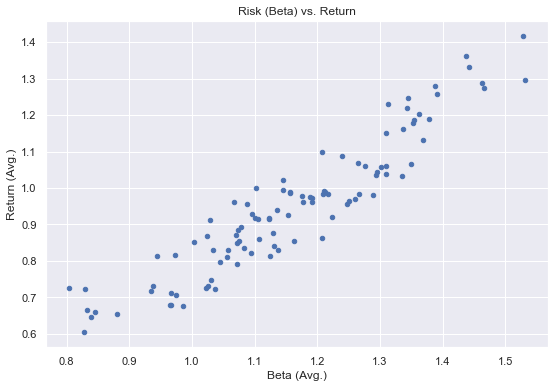

In [4]:
stats.plot(x="mean_b", y="mean_r", grid=True, kind="scatter", figsize=(9,6))

plt.title("Risk (Beta) vs. Return")
plt.xlabel("Beta (Avg.)")
plt.ylabel("Return (Avg.)")

plt.show()

## Statistical Analysis

1. Find which portfolios have a mean beta that isn't statistically different than 1. 
2. Find which portfolios have a mean return that is statistically greater than the mean market return.

To do step 1, I will be using the ttest_1samp function from the scipy library which compares a sample mean against a population mean.

For step 2, I will be using the test_ind function from the scipy library which compares two sample means looking for statistical significance. 

If there are any portfolios that meet both of these criteria, they will be the best portfolios to look at. 

In [5]:
# Step 1
test1 = scipy.stats.ttest_1samp(betas.to_numpy(), 1)
alpha = 0.05

# Get p-value from t-test
p_value = test1.pvalue

# Put in a DataFrame
p_df = pd.DataFrame(p_value, columns=["p-value"])

# Portfolios greater than alpha and number of of Portfolios less than alpha.
# The Null Hypothesis is that the mean of the portfolio is equal to 1. 
# The Alternative Hypothesis is that the mean is different from 1. 
stat_diff_betas = p_df < alpha
print(list(p_df[stat_diff_betas!=True].dropna().index))
print(stat_diff_betas.sum()[0])

[65]
99


In this statistical test, I am trying to find portfolios that have a mean beta that isn't statistically different from 1 or that fail to reject the Null Hypothesis. Portfolio 65 is the only portfolio that meets this criteria in this case. All other portfolios have a statistically different mean than 1. 

In [6]:
# Step 2
p_returns = returns.drop("return", axis=1)
m_returns = returns["return"].dropna()

def returns_test(portfolios, market_return, alpha=0.05, test_type="greater"):
    stat_diff_returns = []
    
    for portfolio in portfolios.columns:
        test = scipy.stats.ttest_ind(portfolios[portfolio].to_numpy(), 
                                     market_return.to_numpy(), 
                                     nan_policy="omit", alternative=test_type)
        p_value = test.pvalue
        
        if p_value < alpha:
            stat_diff_returns.append(portfolio)
        else:
            continue
    
    return stat_diff_returns

# Number of portfolios with a statistically greater mean return. Portfolios that meet this criteria.
results = returns_test(p_returns, m_returns)
print(f"Number of portfolios: {len(results)}")
print(results)

Number of portfolios: 75
['0', '1', '2', '4', '5', '6', '8', '10', '12', '13', '14', '16', '17', '18', '19', '20', '21', '22', '24', '25', '28', '30', '31', '33', '34', '35', '36', '37', '38', '39', '43', '46', '47', '49', '50', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '64', '65', '66', '68', '69', '70', '71', '72', '73', '74', '75', '77', '78', '79', '80', '82', '83', '84', '85', '87', '88', '89', '90', '91', '92', '93', '96', '98', '99']


Most of the portfolios also have a mean return statistically higher than the market. Portfolio 65 is the only one that falls into this category and the other category. 

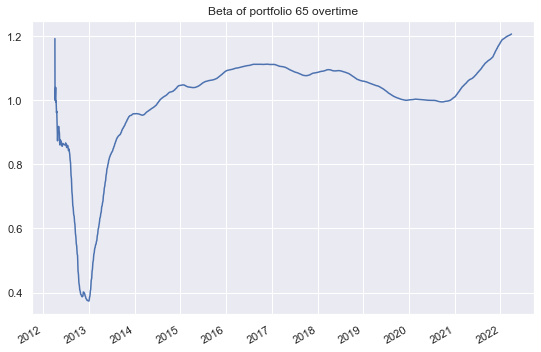

In [7]:
betas["65"].plot(grid=True, figsize=(9,6))

plt.title("Beta of portfolio 65 overtime")

plt.show()

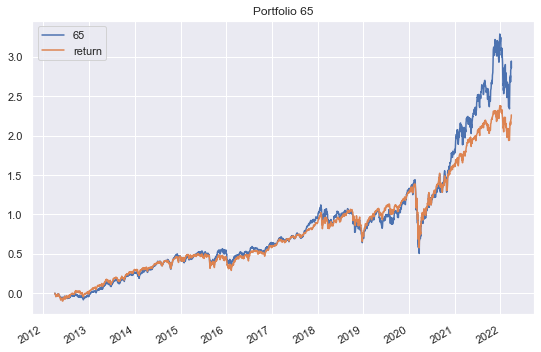

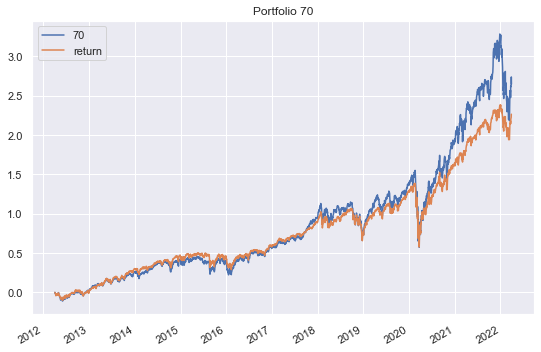

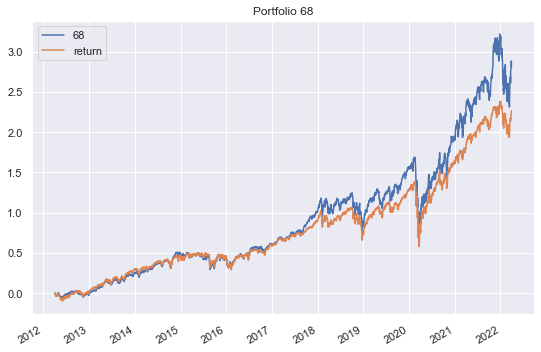

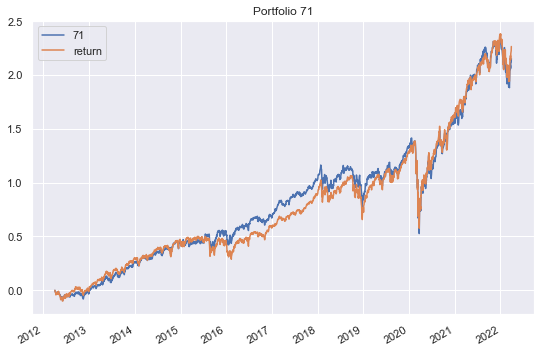

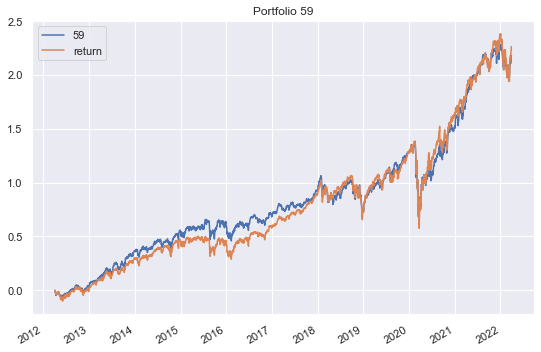

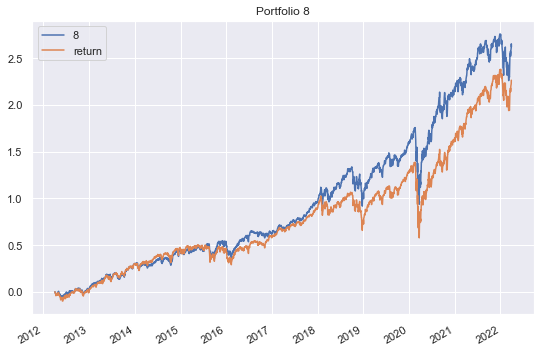

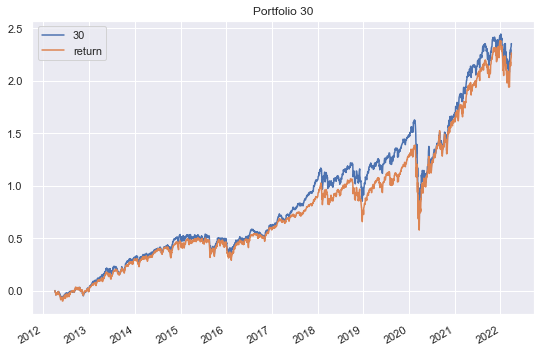

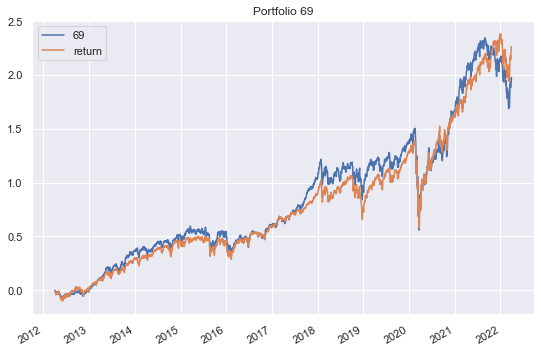

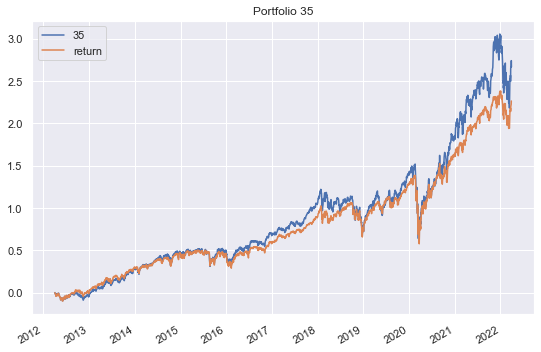

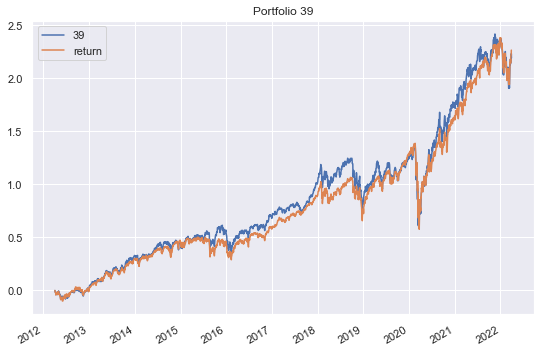

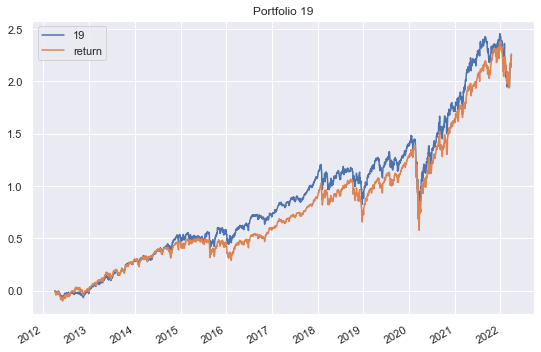

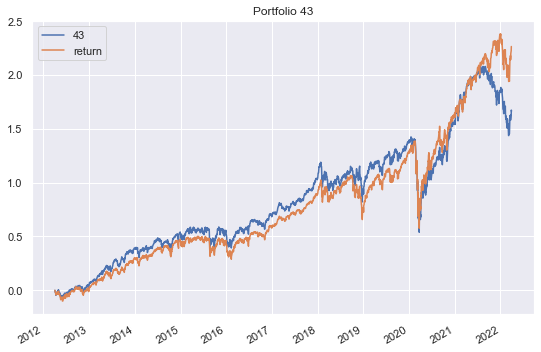

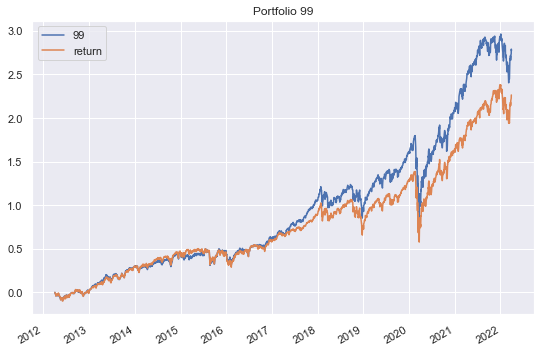

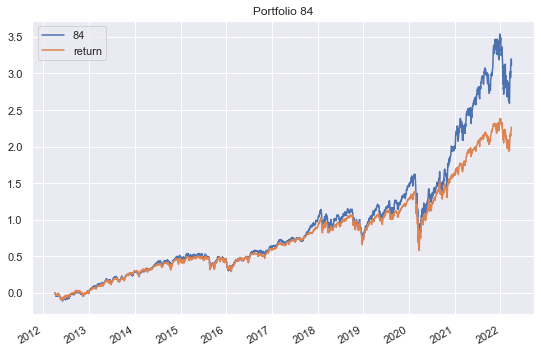

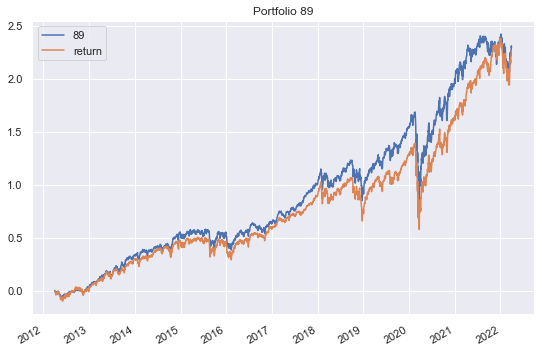

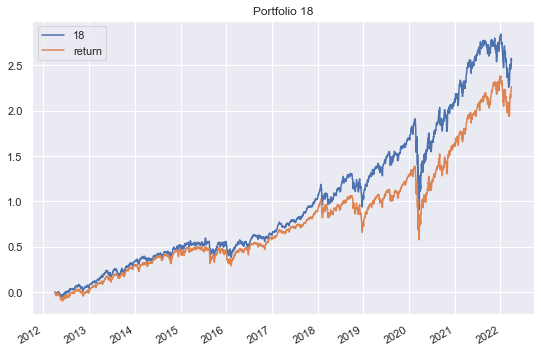

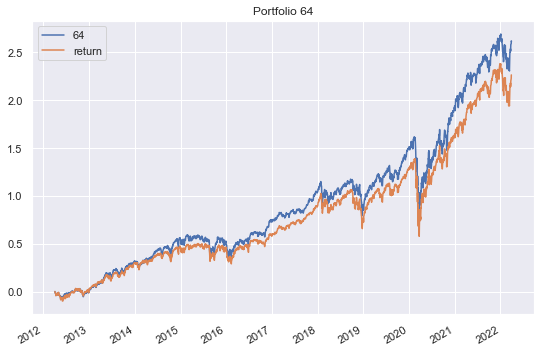

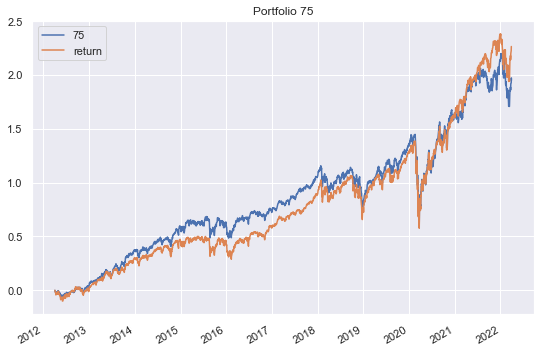

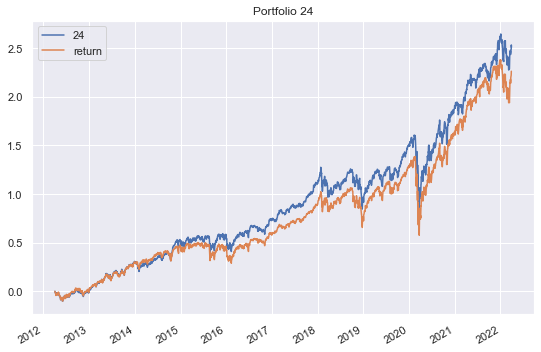

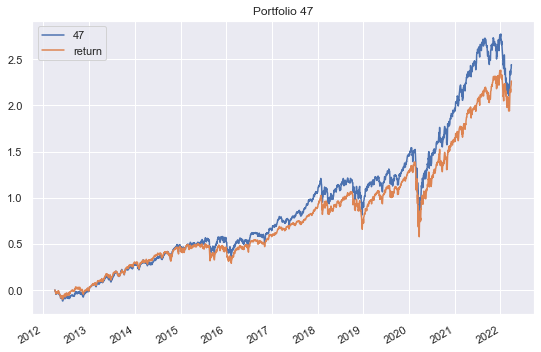

In [8]:
# Because 75 portfolios is a lot to visualize, I will narrow this collection of portfolios to the top 10 with the 
# lowest mean beta. 
low_beta = list(stats.iloc[results].sort_values("mean_b").head(20).index)

for portfolio in low_beta:
    returns[[portfolio, "return"]].plot(grid=True, figsize=(9, 6))
    
    plt.title(f"Portfolio {portfolio}")
    plt.show()

These graphs show portfolios that respond to movements in the market, but also outperform the market as well. 

In [9]:
low_beta_stocks = stocks[low_beta]
low_beta_stocks

,65,70,68,71,59,8,30,69,35,39,19,43,99,84,89,18,64,75,24,47
0,ABBV,ACN,ACN,BAC,ABT,ABT,ABT,ABT,BMY,AMZN,AMGN,AMGN,ABBV,ALL,ABT,ABT,AAPL,AAPL,AAPL,ABT
1,BK,BK,AMGN,DD,BAC,ACN,ALL,AXP,DD,C,CSCO,AXP,ACN,COF,AMGN,BAC,AIG,ALL,ABBV,AMGN
2,BMY,COP,BA,EMR,CL,AMZN,BA,BA,FDX,CVX,DHR,BA,ALL,COP,BMY,BIIB,COP,BK,BK,BAC
3,COF,COST,CL,FB,CMCSA,BK,BMY,BIIB,GOOGL,DIS,DOW,CMCSA,BAC,CSCO,COP,COF,DIS,CMCSA,C,CAT
4,DD,CSCO,DOW,FOX,COF,BMY,CAT,BLK,HAL,DOW,DUK,COF,CMCSA,CVS,COST,COST,GE,CVS,COST,COST
5,DOW,GE,EMR,GD,COST,CVX,CL,BMY,IBM,F,FB,CVX,COP,DHR,DD,DOW,GM,F,GE,F
6,F,HAL,GD,GOOGL,CVS,DHR,DUK,COP,INTC,FDX,FDX,DHR,DUK,GOOG,DUK,DUK,HON,FB,GS,FB
7,FOX,HD,INTC,IBM,DD,DUK,GOOG,DOW,JPM,FOXA,FOXA,GM,GOOGL,GS,EMR,EXC,INTC,FDX,HON,GE
8,GE,IBM,JNJ,KO,DHR,FOX,JPM,FOXA,LMT,GD,GOOG,JNJ,JNJ,HON,FOX,GOOGL,JNJ,FOX,INTC,GS
9,JNJ,JNJ,MDLZ,MDT,GM,GS,KMI,GOOG,MDLZ,GOOG,INTC,JPM,MA,IBM,FOXA,HD,KMI,GM,JNJ,IBM


In [10]:
counts = {}

for stock in low_beta_stocks.columns:
    for i in low_beta_stocks[stock]:
        if i in counts:
            counts[i] += 1
        else: 
            counts[i] = 1

c_df = pd.DataFrame({"Name": list(counts.keys()), "Value": list(counts.values())})
c_df = c_df[c_df.Value > 4].sort_values("Value", ascending=True)

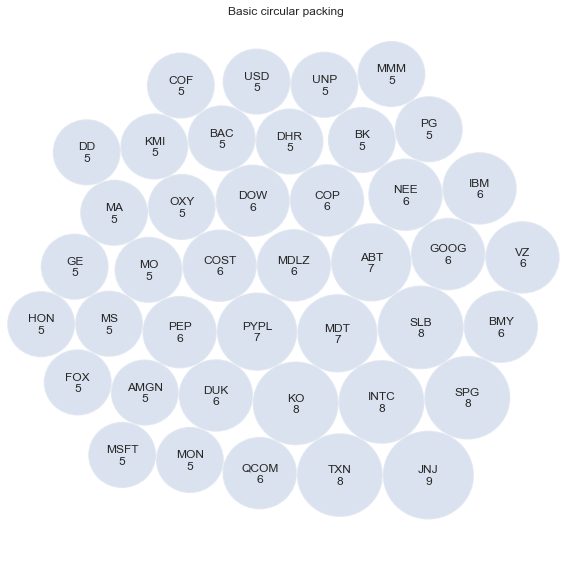

In [11]:
# import libraries
import circlify

circles = circlify.circlify(
    c_df['Value'].tolist(), 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(10,10))

# Title
ax.set_title('Basic circular packing')

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = c_df['Name'] + "\n" + c_df["Value"].astype(str)

# print circles
for circle, label in zip(circles, labels):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2))
    plt.annotate(
          label, 
          (x,y ) ,
          va='center',
          ha='center'
     )

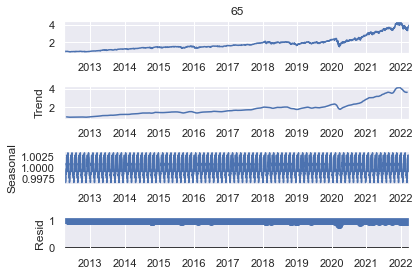

<Figure size 2160x1080 with 0 Axes>

In [17]:
# Look at the seasonal decomposition of portfolio 65.
# Because of how the returns are calculated there are negative values. This doesn't work with a multiplicative model.
# Adding 1 to each return mitigates this problem and also makes intuitive sense as a return of the percentage of the initial investment.
sm.tsa.seasonal_decompose(returns["65"].apply(lambda x: x+1), period=253, model="multiplicative").plot()
plt.figure(figsize=(30, 15))
plt.show()